# Estimate the number of book events missing from the dataset.

Book events almost exclusively tracked through the circulation cards, but how many cards survived is unknown and varies dramatically with time. With this in mind can we estimate the total circulation?

Notes
* We will focus exclusively on dates prior to 1942, which leaves out approximately 2 percent
* Only subscription events with solid start and end dates will be used in calculating the book event estimate. This excludes six percent of subscription events.

In [1]:
import pandas as pd
from datetime import datetime, date, timedelta

%matplotlib inline

In [2]:
MISSING_MEMBERS_ESTIMATE = 0.9118

In [3]:
csv_urls = {
    'members': 'https://dataspace.princeton.edu/bitstream/88435/dsp01b5644v608/2/SCoData_members_v1.1_2021-01.csv',
    'books': 'https://dataspace.princeton.edu/bitstream/88435/dsp016d570067j/2/SCoData_books_v1.1_2021-01.csv',
    'events': 'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])

# Create book events summary

In [4]:
# How many book events do we have?
book_events = events_df[~events_df.item_uri.isna()]
book_events.shape[0]

22479

In [5]:
# How many book events come from logbooks
book_events[book_events['source_type'] == 'Logbook'].shape[0]

23

In [6]:
# How many book events with unknown dates are there?
print(book_events.start_date.isna().sum())
# Let's drop them
book_events = book_events.dropna(subset=['start_date'])

166


In [7]:
# How many book events occur after 1942?
book_events['start_date'] = pd.to_datetime(book_events['start_date'], errors='coerce')
book_events = book_events.dropna(subset=['start_date'])
book_events_after_1942 = book_events[book_events['start_date'] >= datetime(1942, 1, 1)]
book_events_after_1942.shape[0]

473

In [8]:
# What proportion of the data occurs here?
print(round(book_events_after_1942.shape[0] / book_events.shape[0] * 100, 2))
# Let's drop these events after 1942
book_events = book_events[book_events['start_date'] < datetime(1942, 1, 1)]

2.13


In [9]:
# What percent of members have a card?
round(members_df[members_df['has_card']].shape[0] / members_df.shape[0] * 100, 2)

11.66

# How constant are subscription habits?

Ideally, we'd be able to extrapolate from the borrowing rates of the cards that we have to estimate how many book events we don't have.


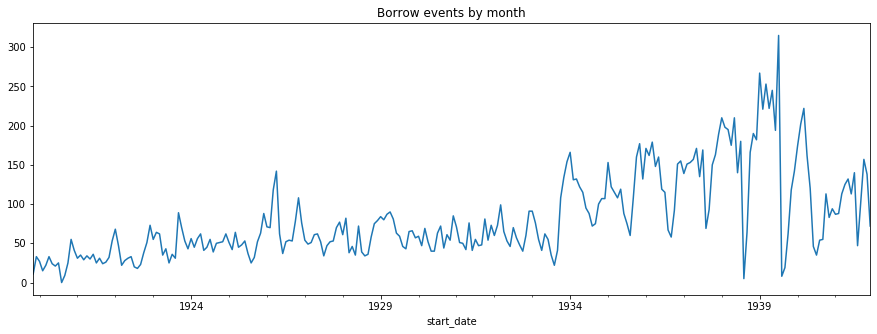

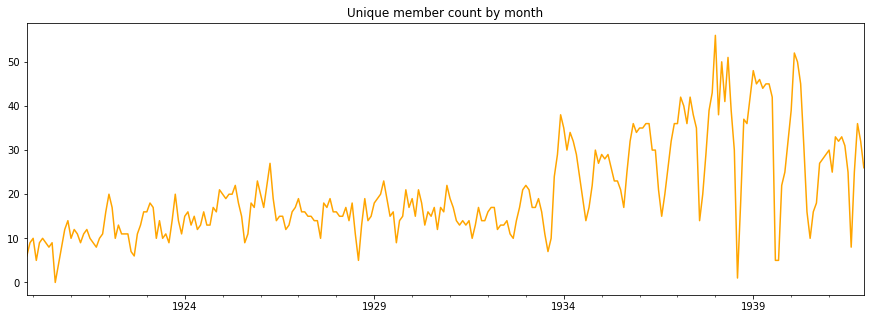

In [10]:
monthly_count = book_events.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
monthly_count.plot(figsize=(15, 5), title='Book events by month')

# for each month get the count of the unique active members
monthly_groups = book_events.groupby([pd.Grouper(key='start_date', freq='M')])
member_count = []
for i, df in monthly_groups:
    # HACK: member_uris is multivalued
    member_count.append([i, df['member_uris'].unique().shape[0]])
    
member_count_df = pd.DataFrame([x[1] for x in member_count], index=pd.to_datetime([x[0] for x in member_count]))
member_count_df.plot(figsize=(15, 5), legend=False, title='Unique member count by month', color='orange')

**Given the consistency between these two graphs we can largely extrapolate that the reading habits of active members was largely consistent**

count    265.000000
mean       3.831664
std        0.954511
min        1.600000
25%        3.117647
50%        3.750000
75%        4.366667
max        7.500000
Name: book_event_per_active_member, dtype: float64


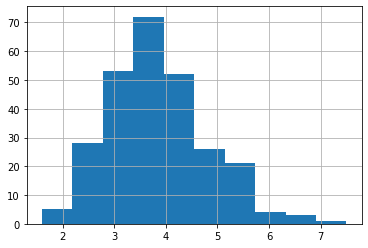

In [11]:
# Get the proportion of book events per active member
member_count_df.columns = ['member_count']
member_count_df['book_events'] = monthly_count
member_count_df['book_event_per_active_member'] = member_count_df['book_events'] / member_count_df['member_count']

print(member_count_df['book_event_per_active_member'].describe())
member_count_df['book_event_per_active_member'].hist()

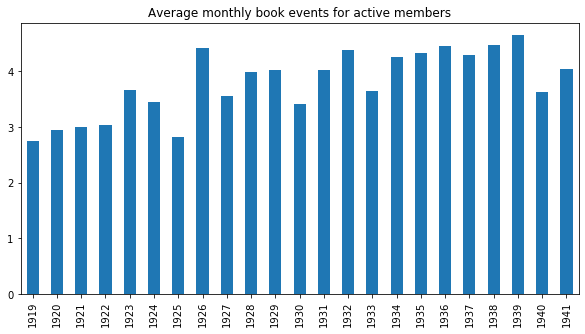

In [12]:
# Going by month seems overkill, let's group by year
proportion_by_year = member_count_df['book_event_per_active_member'].groupby([pd.Grouper(freq='Y')]).mean()
proportion_by_year.index = proportion_by_year.index.year
ax = proportion_by_year.plot(kind='bar', title='Average monthly book events for active members', figsize=(10, 5))
ax

# Apply reading habits to monthly membership


In [22]:
# How many unique active members are mentioned each month in the logbooks?
member_events = events_df[events_df.item_uri.isna()].copy()
member_events['start_date'] = pd.to_datetime(member_events.start_date, errors='coerce')
member_events['end_date'] = pd.to_datetime(member_events.end_date, errors='coerce')

# How many null values occur in start or end date?
print(member_events.start_date.isna().sum())
print(member_events.end_date.isna().sum())
# Drop these
member_events = member_events.dropna(subset=['start_date', 'end_date'])

13
670


In [29]:
def active_count(df_t, d):
    return df_t[(df_t.start_date <= d) & (df_t.end_date >= d)].shape[0]

monthly_membership_count = {}
month_range = pd.date_range('1919-11-01','1941-12-01', freq='MS').tolist()
for month in month_range:
    monthly_membership_count[month] = active_count(member_events, month)
    
estimated_book_event_count = {}
for month, count in monthly_membership_count.items():
    estimated_book_event_count[month] = 3.7 * count / MISSING_MEMBERS_ESTIMATE

Text(0.5, 0, '')

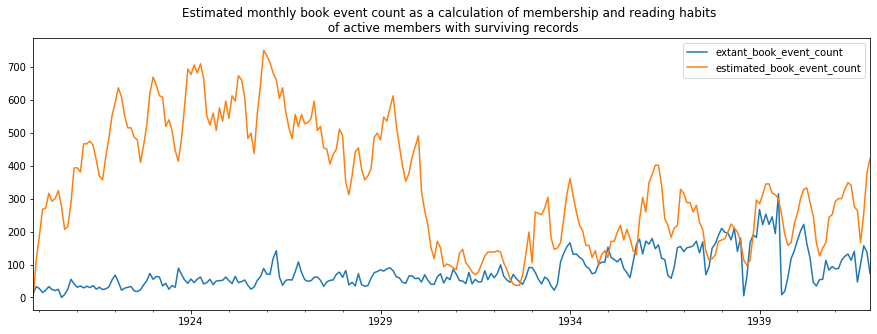

In [30]:
comparison_df = pd.DataFrame(monthly_count)
comparison_df.columns = ['extant_book_event_count']
comparison_df['estimated_book_event_count'] = estimated_book_event_count.values()
ax = comparison_df.plot(figsize=(15, 5), title='Estimated monthly book event count as a calculation of membership and reading habits \n of active members with surviving records')
ax.set_xlabel('')

In [31]:
comparison_df['extant_book_event_count'].sum()

21767

In [26]:
# What is the estimated number of missing book events
missing_book_event_estimate = comparison_df['estimated_book_event_count'].sum() 
round(missing_book_event_estimate)

89915.0

In [27]:
# What proportion of the estimated book events are contained in the dataset
round(comparison_df['extant_book_event_count'].sum() / missing_book_event_estimate * 100, 2)

24.21